# Libraries

Installation

In [147]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 8.3/8.3 MB 10.4 MB/s eta 0:00:00
     ---------------------------------------- 42.2/42.2 MB 6.8 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 1.7 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading

In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
pd.set_option('display.max_columns', None)

# Data Import And Cleaning

## Importation and Initial Cleaning

Data is imported and column names are standardized to lower case english. The suffix "_s" in the assigned column names corresponds to the "scheduled" values. Since the city code of origin is identical for the scheduled and operation flights, the column `Ori-O` it is dropped. Also, considering there is a column for tha date of operation, the columns `DIA`, `MES` and `AÑO` are not necessary, so they are also dropped. The column of scheduled date without time `date_wo_time_s` is added.

Note: The argument `low_memory` is set to `False` to avoid mixed types inside columns when importing.

In [437]:
flights_w_duplicates = pd.read_csv('data/dataset_SCL.csv', parse_dates = ['Fecha-I', 'Fecha-O'],
                      low_memory = False) \
    .rename(columns = {'Fecha-I':'date_s', 'Vlo-I':'flight_s', 'Ori-I':'city_code_origin_s', 
                       'Des-I':'city_code_destination_s', 'Emp-I':'airline_code_s', 
                       'Fecha-O':'date_o', 'Vlo-O':'flight_o',
                       'Des-O':'city_code_destination_o', 'Emp-O':'airline_code_o', 
                       'DIANOM':'wday_o', 'TIPOVUELO':'type', 'OPERA':'airline_o', 
                       'SIGLAORI':'city_origin', 'SIGLADES':'city_destination'}) \
    .drop(['DIA', 'MES', 'AÑO', 'Ori-O'], axis = 1)
flights_w_duplicates['date_wo_time_s'] = flights_w_duplicates['date_s'].dt.date
flights_w_duplicates.head()

,date_s,flight_s,city_code_origin_s,city_code_destination_s,airline_code_s,date_o,flight_o,city_code_destination_o,airline_code_o,wday_o,type,airline_o,city_origin,city_destination,date_wo_time_s
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami,2017-01-01
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,Lunes,I,American Airlines,Santiago,Miami,2017-01-02
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,Martes,I,American Airlines,Santiago,Miami,2017-01-03
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,Miercoles,I,American Airlines,Santiago,Miami,2017-01-04
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,Jueves,I,American Airlines,Santiago,Miami,2017-01-05


## Duplicates

We create a function that extracts the duplicated rows for a subset of the columns. If a combination of those columns has more than one row, there is a duplicate.

In [431]:
def extract_duplicates(df, columns_list):
    df = df \
            .groupby(columns_list, group_keys = False) \
            .apply(lambda x: x.assign(n = x.shape[0])).reset_index(drop=True) \
            .sort_values(columns_list)
    df = df[df['n'] > 1]
    return df

Sometimes, there is more than one observation for the same flight number, airline and date. This is an unusual situation and should be reviewed carefully with more information about the industry. For now, this observations are assumed to be valid.

In [432]:
duplicates = extract_duplicates(flights, ['date_wo_time_s', 'flight_s', 'airline_code_s']) 
duplicates

,date_s,flight_s,city_code_origin_s,city_code_destination_s,airline_code_s,date_o,flight_o,city_code_destination_o,airline_code_o,wday_o,type,airline_o,city_origin,city_destination,date_wo_time_s,n
658,2017-01-07 08:40:00,146,SCEL,KATL,DAL,2017-01-07 09:20:00,146,KATL,DAL,Sabado,I,Delta Air,Santiago,Atlanta,2017-01-07,2
659,2017-01-07 21:50:00,146,SCEL,KATL,DAL,2017-01-07 21:44:00,146,KATL,DAL,Sabado,I,Delta Air,Santiago,Atlanta,2017-01-07,2
1459,2017-01-28 15:05:00,43,SCEL,SCVD,SKU,2017-01-28 15:29:00,43,SCVD,SKU,Sabado,N,Sky Airline,Santiago,Valdivia,2017-01-28,2
2524,2017-01-28 17:00:00,43,SCEL,SCVD,SKU,2017-01-28 16:56:00,43,SCVD,SKU,Sabado,N,Sky Airline,Santiago,Valdivia,2017-01-28,2
7519,2017-02-26 06:40:00,71,SCEL,SCIE,SKU,2017-02-26 06:45:00,71,SCIE,SKU,Domingo,N,Sky Airline,Santiago,Concepcion,2017-02-26,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55501,2017-10-21 12:30:00,600,SCEL,SPJC,LAW,2017-10-21 13:01:00,600,SPJC,JMR,Sabado,I,Latin American Wings,Santiago,Lima,2017-10-21,2
55470,2017-10-23 00:30:00,402,SCEL,SAME,LAW,2017-10-23 01:17:00,402,SAME,JMR,Lunes,I,Latin American Wings,Santiago,Mendoza,2017-10-23,2
55471,2017-10-23 22:40:00,402,SCEL,SAME,LAW,2017-10-23 23:49:00,402,SAME,JMR,Lunes,I,Latin American Wings,Santiago,Mendoza,2017-10-23,2
61548,2017-11-13 00:40:00,402,SCEL,SAME,LAW,2017-11-13 01:12:00,402,SAME,JMR,Lunes,I,Latin American Wings,Santiago,Mendoza,2017-11-13,2


There is however a stranger duplicate, that contains exactly the same information for all columns, except the operation time of the flight. It corresponds to a flight operated by SKY, from Santiago to Puerto Montt. This case should probably not happen, so its two rows are deleted. The final data frame that will be used for analysis and modeling is `flights`.

In [450]:
print('Rows before removal of duplicates: ' + str(len(flights_w_duplicates)))
duplicates_with_time = extract_duplicates(flights_w_duplicates, ['date_s', 'flight_s', 'airline_code_s'])
print('Duplicates with time:')
display(duplicates_with_time)
flights_w_duplicates = flights_w_duplicates \
        .groupby(['date_s', 'flight_s', 'airline_code_s'], group_keys = False) \
        .apply(lambda x: x.assign(n = x.shape[0])).reset_index(drop=True)
flights = flights_w_duplicates[flights_w_duplicates['n'] == 1].copy()
print('Rows after removal of duplicates: ' + str(len(flights)))

Rows before removal of duplicates: 68206
Duplicates with time:


,date_s,flight_s,city_code_origin_s,city_code_destination_s,airline_code_s,date_o,flight_o,city_code_destination_o,airline_code_o,wday_o,type,airline_o,city_origin,city_destination,date_wo_time_s,n
12719,2017-03-26 08:55:00,1,SCEL,SCTE,SKU,2017-03-26 10:00:00,1,SCTE,SKU,Domingo,N,Sky Airline,Santiago,Puerto Montt,2017-03-26,2
13905,2017-03-26 08:55:00,1,SCEL,SCTE,SKU,2017-03-26 09:02:00,1,SCTE,SKU,Domingo,N,Sky Airline,Santiago,Puerto Montt,2017-03-26,2


Rows after removal of duplicates: 68204


# Data Distribution

## Number of Flights Over Time

The number of flights per day is examined in the following plot. There is an apparent weekly seasonality with a lot of variability.

<Axes: xlabel='date_s'>

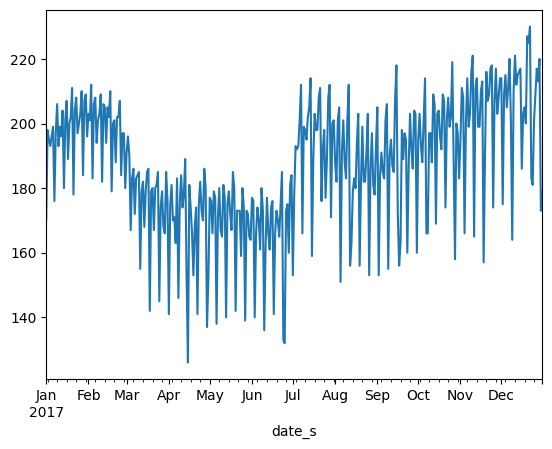

In [441]:
flights.resample('D', on = 'date_s').size().plot()

In order to eliminate the weekly seasonality and observe more easily the trends, the number of flight per week is also plotted. In this plot we observe that the first and last weeks contain less flights, but this is due to the fact that they do not contain 7 days. Also, there is a decrease of flights between march and june. Finally, it is woth mentioning that the pick of flights is at the end of december, probably due to people flying for the holidays.

<Axes: xlabel='date_o'>

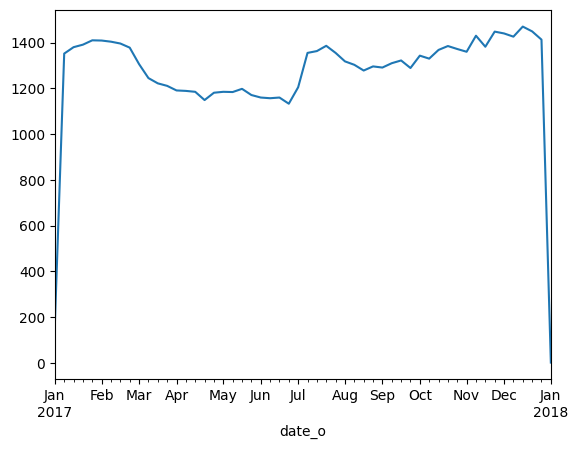

In [442]:
flights.resample('W', on = 'date_o').size().plot()

In order to analize the weekly seasonality, the mean number of flights per day of the week is shown in the following plot. It is observed that Friday is the week day with more flights and Saturday is the day with less flights. 

<Axes: xlabel='wday_s'>

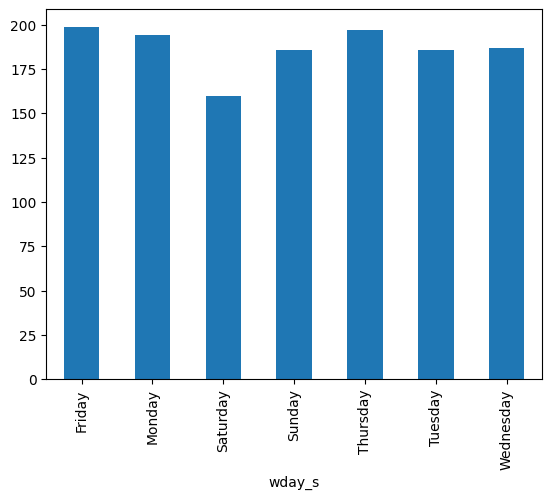

In [459]:
flights['wday_s'] = flights['date_s'].dt.day_name()
flights['wday_s']
flights.groupby(['date_wo_time_s', 'wday_s']).size().reset_index(name = 'n') \
    .groupby('wday_s')['n'].mean().plot(kind = 'bar')

## Origins and Destinations

### Origins

All flights take off from Santiago.

In [471]:
flights['city_origin'].value_counts()

Santiago    68204
Name: city_origin, dtype: int64

### Destinations

None of the flights lands in Santiago. The data is supossed to have observations of flights that land in Santiago too, so there might be an issue with the provided file. Nevertheless, the analysis is continued with this warning in mind.

In [469]:
sum(flights['city_code_destination_o'] == 'SCEL')

0

Buenos Aires, Antofagasta, Lima and Calama are the most popular destinations. Also, there are some destinations with very few flights, such as Washington.

<Axes: xlabel='city_destination'>

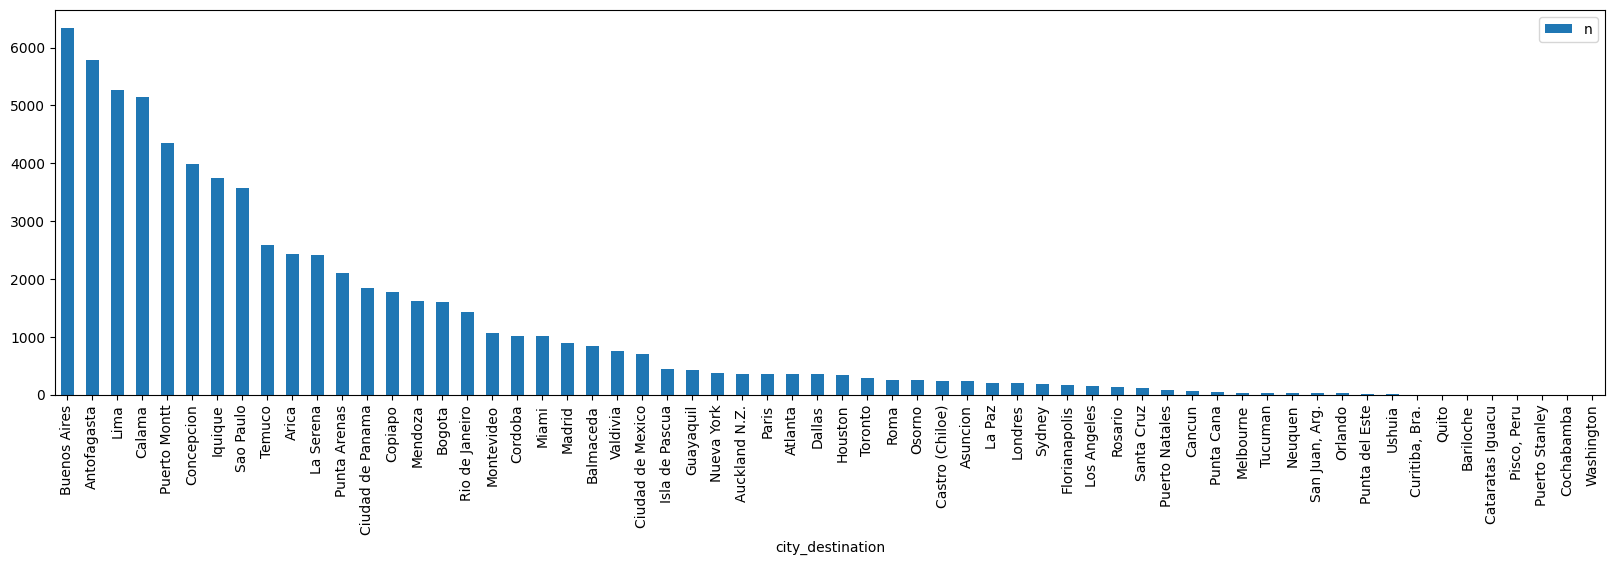

In [472]:
flights.groupby('city_destination').size().reset_index(name = 'n') \
    .sort_values('n', ascending = False) \
    .plot(x = 'city_destination', y = 'n', kind = 'bar', figsize=(20, 5))

There are more national flights than international ones.

<Axes: xlabel='type'>

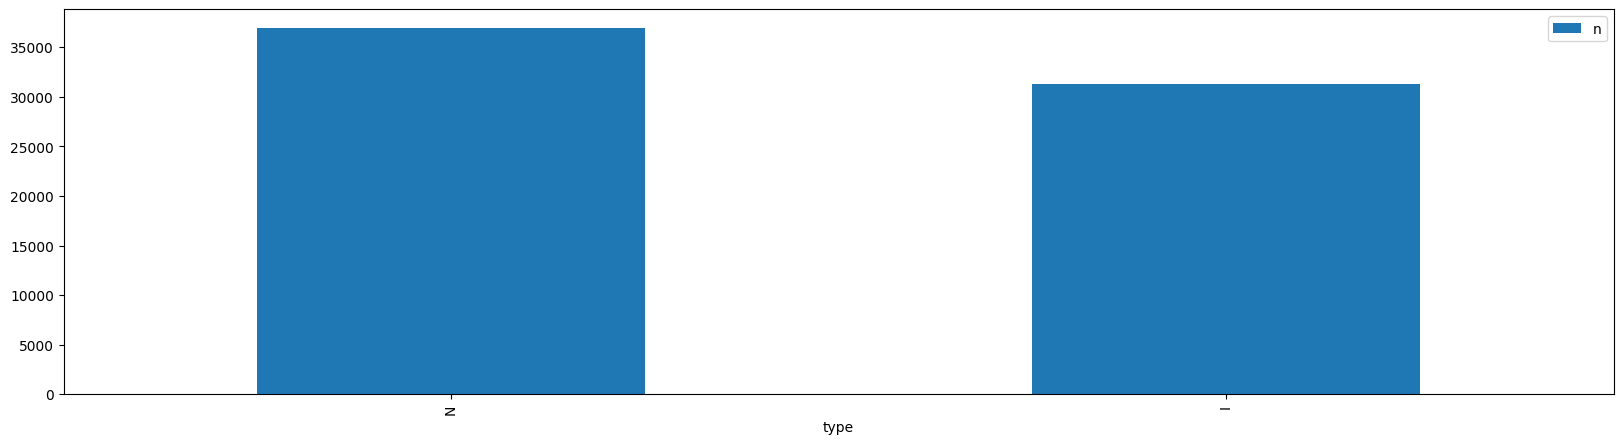

In [474]:
flights.groupby('type').size().reset_index(name = 'n') \
    .sort_values('n', ascending = False) \
    .plot(x = 'type', y = 'n', kind = 'bar', figsize=(20, 5))

There are 28 cases where the city of destination is different for the scheduled and operated flights. This is probably because sometimes the operated flight requires a stopover not previously considered in the scheduled flight.

In [486]:
sum(flights['city_code_destination_s'] != flights['city_code_destination_o'])

28

## Flights by Airline

Sometimes different airline codes have the same airline name. In particular, Grupo Latam has 7 different codes in 2017, which probably correspond to the same group of airlines in different countries.

In [114]:
flights.groupby(['airline_o', 'airline_code_o']).size().reset_index(name = 'n').sort_values(['airline_o', 'n'], ascending = [True, False])

,airline_o,airline_code_o,n
0,Aerolineas Argentinas,ARG,1944
1,Aerolineas Argentinas,AUT,5
2,Aeromexico,AMX,351
3,Air Canada,ACA,565
4,Air France,AFR,358
5,Alitalia,AZA,259
6,American Airlines,AAL,757
8,Austral,AUT,72
7,Austral,ARG,2
9,Avianca,AVA,885


In some cases, the code of the airline that operates is different than the code of the scheduled airline. Nevertheless, it seems that these cases only occur within the same airline group (eg Grupo Latam).

In [483]:
flights.columns
pd.DataFrame(
    flights[flights['airline_code_s'] != flights['airline_code_o']] \
    .groupby(['airline_code_s', 'airline_code_o', 'airline_o']) \
    .size() \
    .reset_index(name = 'n') \
    .sort_values('n', ascending = False))
# flights[flights['aeroline_code_s'] != flights['aeroline_code_o']].size('aeroline_code_s', 'aeroline_code_o')

,airline_code_s,airline_code_o,airline_o,n
7,LAN,LXP,Grupo LATAM,14549
10,LAW,JMR,Latin American Wings,1547
6,LAN,LPE,Grupo LATAM,1210
4,LAN,DSM,Grupo LATAM,491
5,LAN,LNE,Grupo LATAM,373
2,AVA,LRC,Avianca,265
11,QFU,QFA,Qantas Airways,195
9,LAW,56R,Latin American Wings,17
8,LAW,48O,Latin American Wings,10
0,ARG,AUT,Aerolineas Argentinas,5


The airline with more flights is Grupo LATAM by far, followed by Sky Airline. The rest of the airlines concentrate a very little percentage of flights.

<Axes: xlabel='airline_o'>

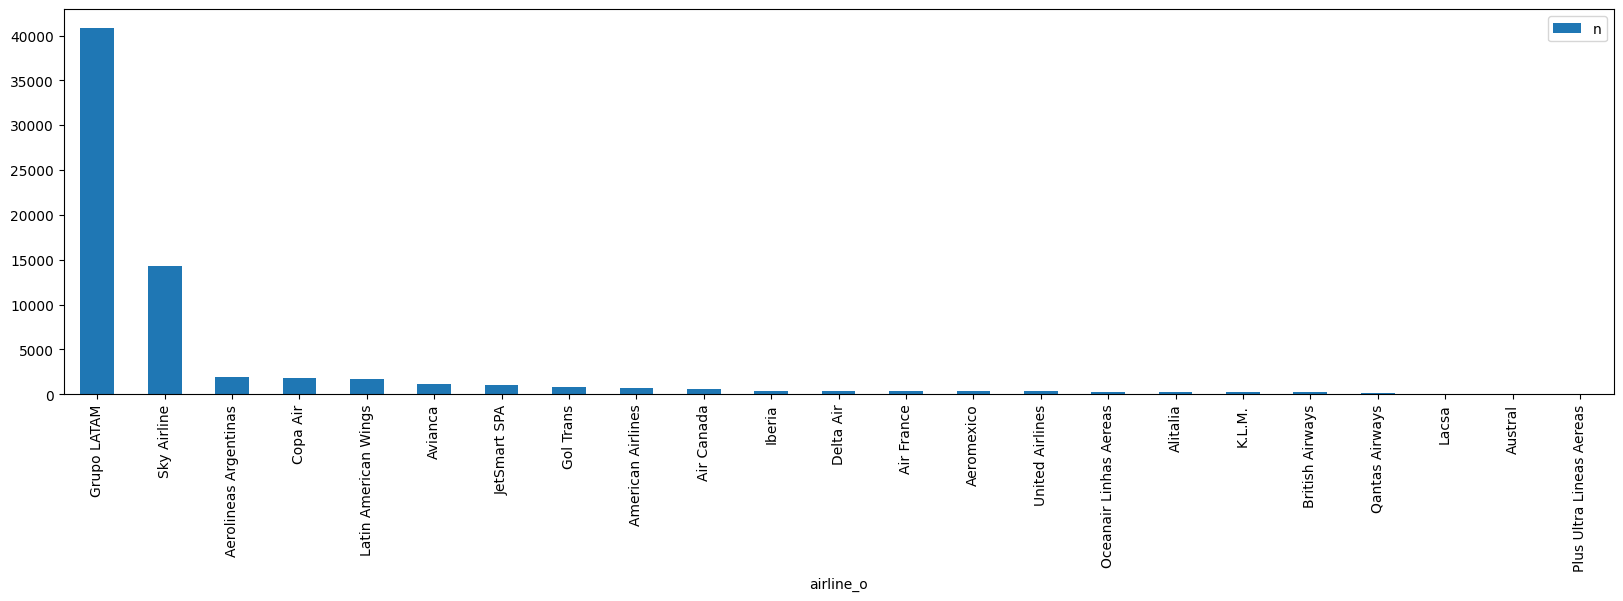

In [484]:
flights.groupby('airline_o').size().reset_index(name = 'n') \
    .sort_values('n', ascending = False) \
    .plot(x = 'airline_o', y = 'n', kind = 'bar', figsize=(20, 5))

# Feature Engineering

The high_season, min_diff, delay_15 and period_day columns are added

In [488]:
# high_season
flights['high_season'] = (flights['date_s'].dt.date <= dt.date(2017, 3, 3)) | \
    (flights['date_s'].dt.date >= dt.date(2017, 12, 15)) | \
    ((flights['date_s'].dt.date >= dt.date(2017, 7, 15)) & 
        (flights['date_s'].dt.date <= dt.date(2017, 7, 31))) | \
    ((flights['date_s'].dt.date >= dt.date(2017, 9, 11)) & 
        (flights['date_s'].dt.date <= dt.date(2017, 9, 30)))
flights['high_season'] = flights['high_season'].astype('int')

# min_diff
flights['min_diff'] = (flights['date_o'] - flights['date_s']).dt.total_seconds() / 60

# delay_15
flights['delay_15'] = flights['min_diff'] > 15
flights['delay_15'] = flights['delay_15'].astype('int')

# period_day
bins_period_day = [-1, 4, 11, 18, 24]
labels_period_day = ['night', 'morning', 'afternoon', 'night']
flights['period_day'] = pd.cut(flights['date_s'].dt.hour, bins = bins_period_day, 
                                 labels = labels_period_day, ordered = False)

Most delays are no longer than 25 minutes. Also, there are some case where the plane takes off before the scheduled time of the flight. This might happen if all the passengers are already inside the plane and the plane is ready to start the flight. In those cases, maybe the flight is allowed to start a little earlier. Also, it is noticed that none of the delays is greater than 3 hours, maybe because in those situations consumers have the right to a compensation (https://www.sernac.cl/portal/607/w3-article-5594.html), so airlines are very carefull to avoid those cases.

count    68204.000000
mean         9.110067
std         19.312483
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: min_diff, dtype: float64


<Axes: ylabel='Frequency'>

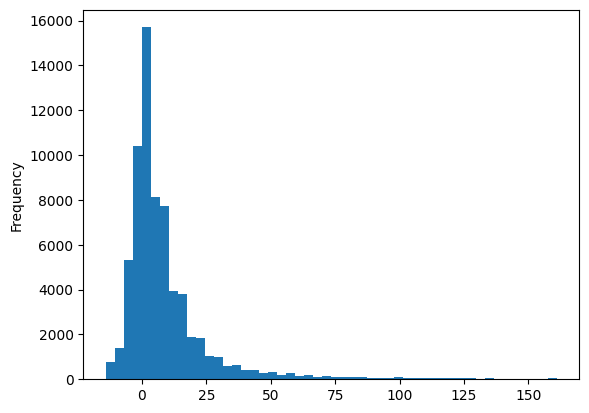

In [495]:
print(flights['min_diff'].describe())
flights['min_diff'].plot(kind = 'hist', bins = 50)

18% of flights have a delay greater than 15 minutes.

In [493]:
flights['delay_15'].value_counts(normalize = True)

0    0.815069
1    0.184931
Name: delay_15, dtype: float64

During nights there are fewer flights than in the morning and the afternoon.

In [492]:
flights['period_day'].value_counts(normalize = True)

afternoon    0.373966
morning      0.371679
night        0.254355
Name: period_day, dtype: float64

# Delay Rate Across Variables

It is assummed that a delay is considered as such only if it is longer than 15 minutes.

## Delay rate by destination

Córdoba, Río de Janeiro y Mendoza son los destinos con mayor tasa de atraso. There is a lot of variability for the delay rate between different destinations.

<Axes: xlabel='city_destination_summarized'>

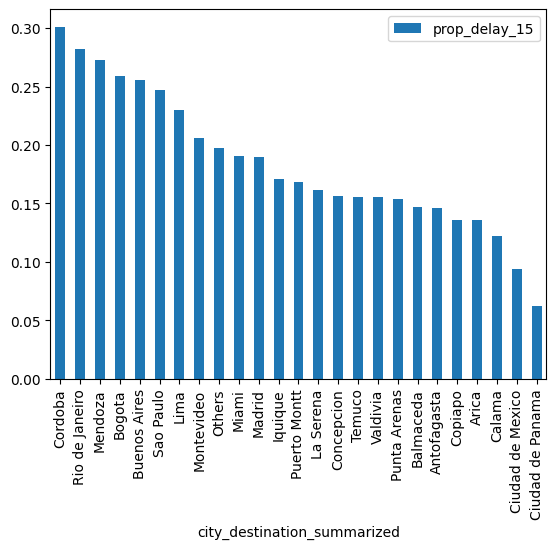

In [498]:
# Cities with less than 500 flights.
flights_by_city = flights.groupby('city_destination').size().reset_index(name = 'n')
cities_less_than_500_flights = flights_by_city.loc[flights_by_city['n'] < 500, 'city_destination']
cities_less_than_500_flights
flights.loc[flights['city_destination'].isin(cities_less_than_500_flights), 
            'city_destination_summarized'] = 'Others' 
flights.loc[~ flights['city_destination'].isin(cities_less_than_500_flights), 
            'city_destination_summarized'] = flights['city_destination'] 
flights
flights.groupby('city_destination_summarized')['delay_15'].agg([np.mean]) \
    .rename(columns = {'mean':'prop_delay_15'}) \
    .reset_index() \
    .sort_values('prop_delay_15', ascending = False) \
    .plot(x = 'city_destination_summarized', kind = 'bar')

## Delay rate by airline

The scheduled airline code with more delay rate is by far QFU. For this analysis it is assumed that this code is a real airline, although it may refer to a type of airline code (https://en.wikipedia.org/wiki/Aeronautical_Code_signals), in which case the interpretation for the data of the code might change.

<Axes: xlabel='airline_code_s_summarized'>

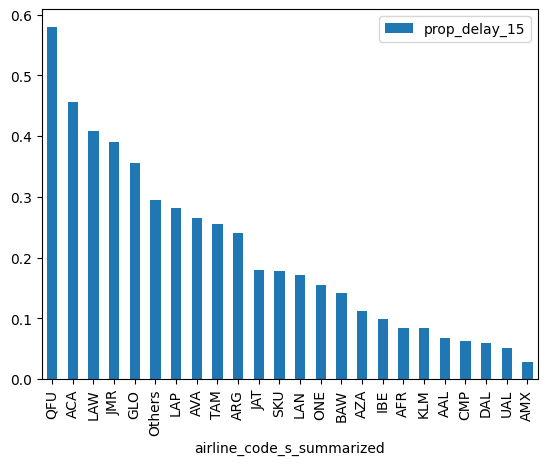

In [499]:
# Cities with less than 100 flights.
flights_by_airline = flights.groupby('airline_code_s').size().reset_index(name = 'n')
airlines_less_than_100_flights = flights_by_airline.loc[flights_by_airline['n'] < 100, 'airline_code_s']

flights.loc[flights['airline_code_s'].isin(airlines_less_than_100_flights), 
            'airline_code_s_summarized'] = 'Others' 
flights.loc[~ flights['airline_code_s'].isin(airlines_less_than_100_flights), 
            'airline_code_s_summarized'] = flights['airline_code_s'] 
flights.groupby('airline_code_s_summarized')['delay_15'].agg([np.mean]) \
    .rename(columns = {'mean':'prop_delay_15'}) \
    .reset_index() \
    .sort_values('prop_delay_15', ascending = False) \
    .plot(x = 'airline_code_s_summarized', kind = 'bar')

## Delay rate by month

The months with more percentage of delays are July and December, probably because there are a lot of flights in those months, while march is the month with less delay rate.

In [135]:
flights.resample('M', on = 'date_s')['delay_15'].agg([np.mean]) \
    .rename(columns = {'mean':'prop_delay_15'}) \
    .reset_index() \
    .sort_values('prop_delay_15', ascending = False)

,date_s,prop_delay_15
6,2017-07-31,0.293440
11,2017-12-31,0.254051
9,2017-10-31,0.225962
10,2017-11-30,0.197336
7,2017-08-31,0.173398
8,2017-09-30,0.172371
5,2017-06-30,0.171016
0,2017-01-31,0.160282
4,2017-05-31,0.157664
1,2017-02-28,0.151591


## Delay rate by day of the week

Friday is the day with more delay rate, while saturday is the day with less.

In [502]:
flights['wday_s'] = flights['date_s'].dt.day_name()
flights.groupby('wday_s')['delay_15'].agg([np.mean]) \
    .rename(columns = {'mean':'prop_delay_15'}) \
    .reset_index() \
    .sort_values('prop_delay_15', ascending = False)

,wday_s,prop_delay_15
0,Friday,0.223480
1,Monday,0.201129
4,Thursday,0.199122
6,Wednesday,0.171705
5,Tuesday,0.169460
3,Sunday,0.162547
2,Saturday,0.159764


## Delay rate by season

Delay rate increases during high season.

In [139]:
flights.groupby('high_season')['delay_15'].agg([np.mean]) \
    .rename(columns = {'mean':'prop_delay_15'}) \
    .reset_index() \
    .sort_values('prop_delay_15', ascending = False)

,high_season,prop_delay_15
1,True,0.19638
0,False,0.17921


## Delay rate by type of flight

International flights are more frequently delayed than national ones. This might be because they require more preparation, since the distances of the trip are longer.

In [140]:
flights.groupby('type')['delay_15'].agg([np.mean]) \
    .rename(columns = {'mean':'prop_delay_15'}) \
    .reset_index() \
    .sort_values('prop_delay_15', ascending = False)

,type,prop_delay_15
0,I,0.225608
1,N,0.150571


## Variables Expected to Influence Delays the Most

Given the greater variability of the delay rate for destinations and airlines, I expect these two variables to have a greater effect than the others in predicting the likelihood of a delay.

# Model for Prediction of Delays

## Data Preparation

### Data Preprocessing

In [181]:
print(flights.columns)
# flights['high_season'].astype(int)
dummy_variables = pd.get_dummies(flights[['wday_s', 'period_day', 'city_destination_summarized', 
                                          'airline_code_s_summarized']], 
                                 drop_first = True)
X = pd.concat([flights[['high_season']], dummy_variables], axis = 1).values
y = flights[['delay_15']].values
print(X)
print(y

Index(['date_s', 'flight_s', 'city_code_origin_s', 'city_code_destination_s',
       'airline_code_s', 'date_o', 'flight_o', 'city_code_origin_o',
       'city_code_destination_o', 'airline_code_o', 'wday_o', 'type',
       'airline_o', 'city_origin', 'city_destination', 'date_wo_time',
       'high_season', 'min_diff', 'delay_15', 'age_category', 'period_day',
       'hour_s', 'city_destination_summarized', 'airline_code_s_summarized',
       'wday_s'],
      dtype='object')
[[1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


### Data Partition

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 20230326, stratify=y)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Logistic Regression

### Training

In [279]:
logistic_regression = LogisticRegression(class_weight = 'balanced', max_iter = 10000)
logistic_regression.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

### Evaluation

Predictions for the test set

In [280]:
y_pred = logistic_regression.predict(X_test)

In [281]:
# print(np.mean(y_pred == np.ravel(y_test)))
logistic_regression.score(X_test, y_test)

0.623075795337927

In [282]:
df_y = pd.DataFrame({'y_pred':y_pred, 'y_test':np.ravel(y_test)})
df_y['a'] = df_y['y_pred'] == df_y['y_test']
df_y['a'].value_counts()
11150/(11150+2492)
df_y['a'].mean()

0.623075795337927

In [283]:
# print(confusion_matrix(y_test, y_pred))
df_y.groupby(['y_test', 'y_pred']).size()

y_test  y_pred
0       0         7027
        1         4092
1       0         1050
        1         1473
dtype: int64

In [284]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.63      0.73     11119
           1       0.26      0.58      0.36      2523

    accuracy                           0.62     13642
   macro avg       0.57      0.61      0.55     13642
weighted avg       0.76      0.62      0.66     13642



In [270]:
2*(0.82*1.00)/(0.82+1.00)
2*(0.576*0.026)/(0.576+0.026)
(0.90+0.05)/2

0.47500000000000003

### Feature Importance

Review of coefficients

In [296]:
# logistic_regression.coef_[0, :]
columns = ['high_season'] + list(dummy_variables.columns)
pd.DataFrame({'column': columns, 'coefficient': logistic_regression.coef_[0, :]}) \
    .sort_values('coefficient')

,column,coefficient
35,airline_code_s_summarized_AMX,-0.468693
2,wday_s_Saturday,-0.455081
55,airline_code_s_summarized_UAL,-0.396483
3,wday_s_Sunday,-0.396171
6,wday_s_Wednesday,-0.351012
...,...,...
42,airline_code_s_summarized_GLO,1.954878
33,airline_code_s_summarized_ACA,2.277921
49,airline_code_s_summarized_LAW,2.459295
45,airline_code_s_summarized_JMR,2.700204


### Potential Model Improvements 

In order to increase model performance, the following ideas could be implemented:

1. Add more data: 
- More observations about flights could be gathered. For example, data for years 2018-2023 or data from other origins than Santiago
- New features could be added, such as weather conditions (some flights might be delayed because of adverse weather), model of the aircraft (some models might be more prone to mechanical problems that could delay flights), the route of the flight (adequate weather conditions may be required for the entire route, not just origin and destination airports), etc. Also, functions of the original predictor variables could also be added (feature engineering)
2. Try new models:
- Some models that were not tried could detect better the patterns for prediction
- Maybe an ensemble model combining different approaches could perform better
- If it were possible to obtain data about the driver of the delays, a different model for each driver could be created. Then, the probabily of a delay because of at least one driver could be calculated from the outputs of those models assuming independence for the drivers if reasonable (a binomial distribution could be used for such approach)
3. Change the response variable:
- Instead of predicting weather a flight will be delayed or not, it is possible to predict the number of minutes that the flight will be delayed. In this case, regression models would be applied instead of the classification approach that was used. This alternative might be attractive considering that 15 minutes is a duration a bit arbitrary for determining that a flight will be delayed. A flight that will be delayed, for example, 14 minutes, might also need to be managed